# RANSAC-based Image Stitching

In [17]:
# Import libraries

import matplotlib.pyplot as plt
import torch
import numpy as np
import kornia
import cv2 as cv
import scipy

## 1) Preprocessing

In [18]:
img_cv1 = cv.imread('parliament-left.jpg')
img_g1 = cv.cvtColor(img_cv1, cv.COLOR_BGR2GRAY)
img_cv2 = cv.imread('parliament-right.jpg')
img_g2 = cv.cvtColor(img_cv2, cv.COLOR_BGR2GRAY)

## 2) Detect keypoints and extract descriptors
- Follows the details on implementing SIFT using the OpenCV library in the provided link to obtain keypoints and descriptors

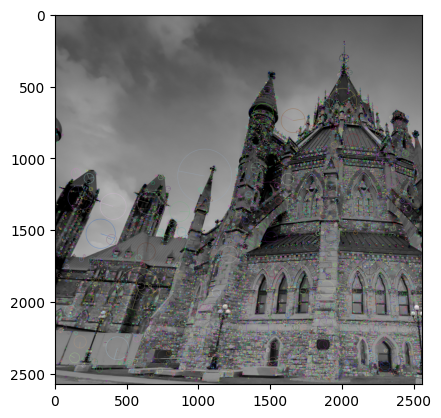

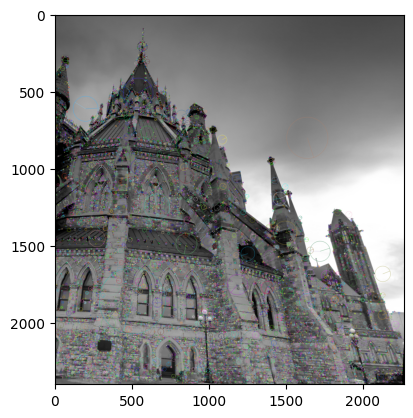

In [19]:
sift = cv.SIFT_create()
# kpN is keypoint for imgN and descN is descriptor for imgN
kp1, desc1 = sift.detectAndCompute(img_g1, None)
kp2, desc2 = sift.detectAndCompute(img_g2, None)

# Drawing keypoints on the corresponding images
output1 = cv.drawKeypoints(img_g1,kp1,img_cv1,flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
output2 = cv.drawKeypoints(img_g2,kp2,img_cv2,flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# Visualizing the keypoints
plt.imshow(output1)
plt.figure()
plt.imshow(output2)

## 3) Match Features

- **matches** returns a tuple where: (<ins>scores</ins>, <ins>match</ins>)
   - <ins>scores</ins> holds the corresponding euclidean distances between the descriptors of img1 and img2 
   - <ins>match</ins> is a tuple of matching descriptors between img1 and img2: (descriptor_from_img1, descriptor_from_img2)

In [20]:
# descN_t is the tensor version of the original descriptor. I did this since the kornia feature matching function requires tensors
desc1_t = torch.tensor(desc1)
desc2_t = torch.tensor(desc2)

scores, matches = kornia.feature.match_snn(desc1_t, desc2_t)

## 4) Prune Features
def prune_features(num_desc_pair)
- I'm choosing 100 of the descriptor pairs with the smallest euclidean distances
- This reduces the matches to the descriptor pairs that are most suitable as inliers
- 'num_desc_pair' The number of descriptor pairs we want to be associate as our inliers

<ins>Computing inliers</ins>
- I find the index of smallest distance of a descriptor pair
- The index of the descriptor (desc) tuple corresponds with index of the keypoints tuple (kp)
- kp.pt is a tuple of the keypoint coordinates

<ins>Resizing img2</ins>
- I need to resize img2 since it's height is smaller than img_g1. The 'np.hstack()' function won't execute if these heights aren't equivalent
- I can achieve equal heights by padding the bottom of img_g2 with the height difference between the two images

In [21]:
# Using a temporary scores as it will be removing the minimum elements in each iteration
scores_temp = torch.clone(scores)
num_desc_pair = 100
computed_inliers = np.zeros((num_desc_pair,4))

for i in range(num_desc_pair):
    # min_index returns the index of the smallest distance in 'scores_temp'
    min_index = torch.argmin(scores_temp)
    
    # Remove the minimum from 'scores_temp' so there is a new minimum in the next iteration
    scores_temp = torch.cat([scores_temp[0:min_index], scores_temp[min_index+1:]])

    # the index of each image's descriptor pairs with the smallest distance
    desc_img1, desc_img2 = matches[min_index]
    
    # img1 keypoint coordinates 
    computed_inliers[i][0], computed_inliers[i][1] = kp1[desc_img1].pt
    
    # img2 keypoint coordinates
    computed_inliers[i][2], computed_inliers[i][3] = kp2[desc_img2].pt

# Resizing img2
img2_resize = np.zeros((img_g1.shape[0], img_g2.shape[1])) # mask that has the same height dimension as img_g1
img2_resize[:img_g2.shape[0],:] = img_g2

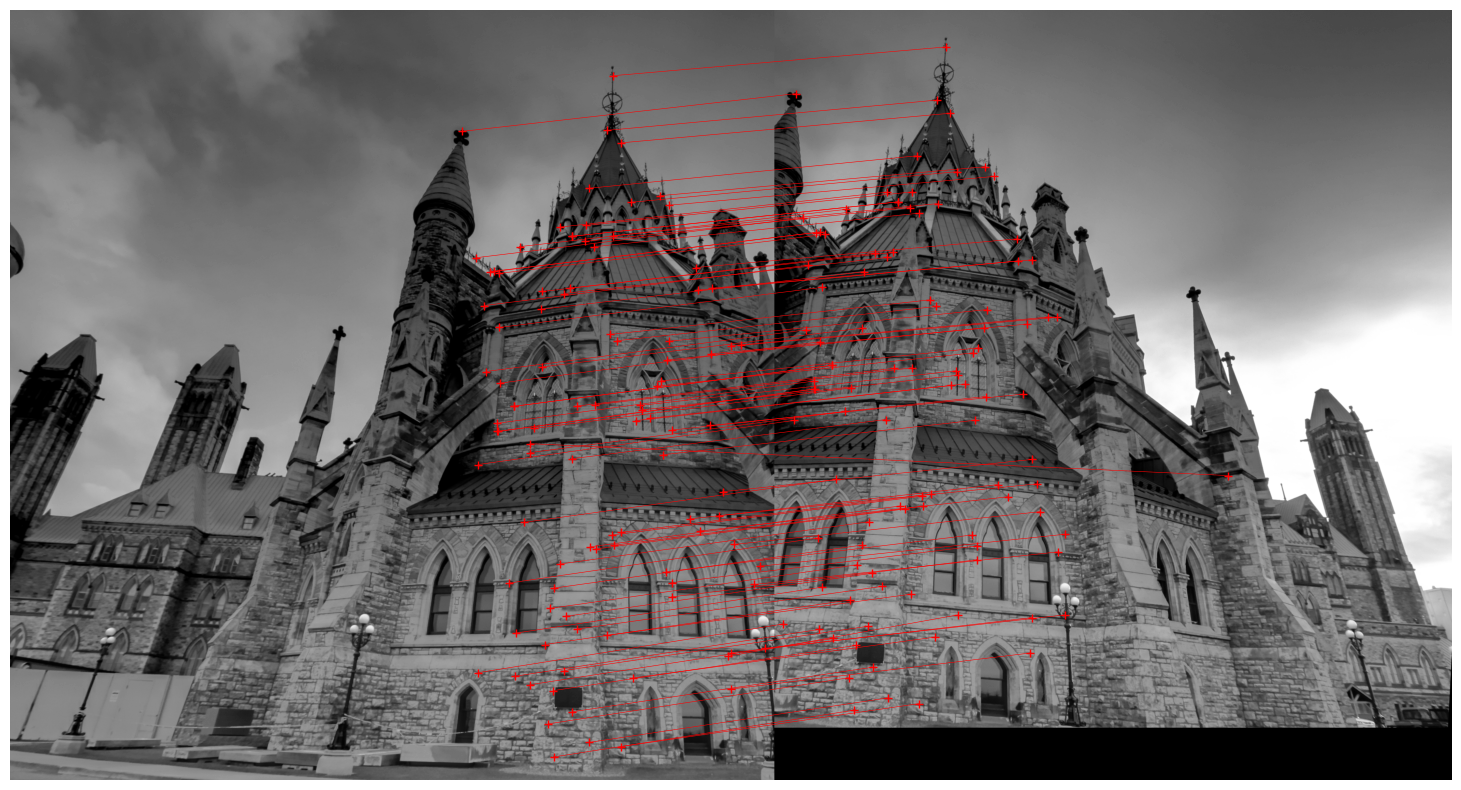

In [22]:
def plot_inlier_matches(ax, img1, img2, inliers):
    """
    Plot the matches between two images according to the matched keypoints
    :param ax: plot handle
    :param img1: left image
    :param img2: right image
    :inliers: x,y in the first image and x,y in the second image (Nx4)
    """
    res = np.hstack([img1, img2])
    ax.set_aspect('equal')
    ax.imshow(res, cmap='gray')
    
    ax.plot(inliers[:,0], inliers[:,1], '+r')
    ax.plot(inliers[:,2] + img1.shape[1], inliers[:,3], '+r')
    # Draw lines
    ax.plot([inliers[:,0], inliers[:,2] + img1.shape[1]],
            [inliers[:,1], inliers[:,3]], 'r', linewidth=0.4)
    ax.axis('off')
    
# Usage:
fig, ax = plt.subplots(figsize=(20,10))
plot_inlier_matches(ax, img_g1, img2_resize, computed_inliers)

## 5) Robust Transformation Estimation
- For RANSAC, I need to determine the best affine transformation matrix out of all the samples (iterations)
- The function will return the inliers of the sample with the best transformation matrix, the one with most satisfiable inlier

<u>Affine Transformation Matrix Derivation</u>

\begin{gather}
\begin{bmatrix}
x'_i \\
y'_i \\
1
\end{bmatrix}=
\begin{bmatrix}
a & b & s_1 \\
c & d & s_2 \\
0 & 0 & 1
\end{bmatrix}\begin{bmatrix}
x \\
y \\
1
\end{bmatrix}
\end{gather}

\begin{equation}
x'_i = a \cdot x + b \cdot y + s_1
\end{equation}
\begin{equation}
y'_i = c \cdot x + d \cdot y + s_2
\end{equation}

With three pair points, we can create 6 formulas for the 6 unknown variables:

\begin{gather}
\begin{bmatrix}
x'_1 \\
y'_1 \\
x'_2 \\
y'_2 \\
x'_3 \\
y'_3 \\
\end{bmatrix}=
\begin{bmatrix}
x_1 & y_1 & 1 & 0 & 0 & 0 \\
0 & 0 & 0 & x_1 & y_1 & 1 \\
x_2 & y_2 & 1 & 0 & 0 & 0 \\
0 & 0 & 0 & x_2 & y_2 & 1 \\
x_3 & y_3 & 1 & 0 & 0 & 0 \\
0 & 0 & 0 & x_3 & y_3 & 1 \\
\end{bmatrix}
\begin{bmatrix}
a \\
b \\
s_1 \\
c \\
d \\
s_2 \\
\end{bmatrix}
\end{gather}


In [23]:
# min_set is the size of minimum point pairs to fit the model
# s is the number of points in a sample
# ransac_n is the number of ransac iterations
# delta is distance threshold

# NOTE: Our minimum point pairs to fit the model is 3! min_set=3 

def ransac(min_set, s, ransac_n, delta):
    # 'computed_inliers_temp' is a numpy array that is changing in size after each iteration.
    #  It removes the descriptor pair at the index of the random generated number
    computed_inliers_temp = np.copy(computed_inliers)
    max_inlier_count = 0
    
    #  Start of RANSAC sample iteration
    for i in range(ransac_n):
        rand_pairs = []
        for j in range(min_set):
            rand = np.random.randint(computed_inliers_temp.shape[0])
            rand_pairs.append([computed_inliers_temp[rand][0], computed_inliers_temp[rand][1], computed_inliers_temp[rand][2], computed_inliers_temp[rand][3]])
            # Deletes descriptor/keypoint pairs once selected to avoid duplicate selection
            computed_inliers_temp = np.delete(computed_inliers_temp, rand, axis=0)

        # Assigning each three point pair to intuitively named variables
        p1_x, p1_y, p1_prime_x, p1_prime_y = rand_pairs[0]
        p2_x, p2_y, p2_prime_x, p2_prime_y = rand_pairs[1]
        p3_x, p3_y, p3_prime_x, p3_prime_y = rand_pairs[2]

        # Inverse Matrix A matrix multiplied with b to calculate x (the affine transformation matrix)
        A = np.array([[p1_x, p1_y, 1, 0, 0, 0], 
                      [0, 0, 0, p1_x, p1_y, 1], 
                      [p2_x, p2_y, 1, 0, 0, 0], 
                      [0, 0, 0, p2_x, p2_y, 1], 
                      [p3_x, p3_y, 1, 0, 0, 0], 
                      [0, 0, 0, p3_x, p3_y, 1]])
        b = np.array([[p1_prime_x], 
                      [p1_prime_y], 
                      [p2_prime_x], 
                      [p2_prime_y], 
                      [p3_prime_x], 
                      [p3_prime_y]])
        A_inverse = np.linalg.inv(A)
        
        # Our current affine transformation matrix 
        x = np.matmul(A_inverse, b)

        # In 3x3 form
        x_matrix = np.array([[x[0].item(), x[1].item(), x[2].item()], [x[3].item(), x[4].item(), x[5].item()], [0, 0, 1]])

        # Now we iterate through every point in the descriptor pair list
        # Each iteration is a unique pair of points in image 1 and image 2
        # We apply the affine transformation to a point in image 1, calculate the distance between that and corresponding point in image 2
        inlier_count = 0
        inliers = []
        for p in computed_inliers_temp:

            p1 = np.array([[p[0]], [p[1]], [1]])
            p1_affine = np.matmul(x_matrix, p1)
            p2 = np.array([[p[2]], [p[3]], [1]])

            # Col vector -> row vector (cartesian coordinate form)
            p1_affine_coord = np.transpose(p1_affine[0:2])
            p2_coord = np.transpose(p2[0:2])

            # Calculate euclidean distance between p1 after affine transformation WITH p2
            dist = scipy.spatial.distance.cdist(p1_affine_coord, p2_coord, 'euclidean')[0].item()

            # INLIER CHECK: If distance between affine transformed p1 and p2 is less than threshold, it is an inlier
            if dist < delta:
                inlier_count += 1
                inliers.append(p)
    
        # Check if current RANSAC iteration has the best affine transformation (iteration with most inliers)
        if inlier_count>max_inlier_count:
            max_inlier_count = inlier_count
            optimal_inliers = inliers

    return optimal_inliers

# RECALL: Our minimum point pairs to fit the model is 3! min_set=3 
inliers = ransac(3, num_desc_pair*2, 20, 0.3)

## 6) Compute Optimal Transformation
- Each iteration adds a pair of rows (two rows appended per inlier pair) to our A matrix

<u>Applying Least Squares Solution</u>
\begin{equation}
x = (A^T A)^{-1} A^T b
\end{equation}
1)
\begin{equation}
C = A^T A
\end{equation}
2)
\begin{equation}
D = A^T b
\end{equation}
3)
\begin{equation}
C^{-1}
\end{equation}
4)
\begin{equation}
x = C^{-1} D
\end{equation}

In [24]:
def optimize_affine_transformation(inliers):
    A = []
    b = []
    for i in inliers:
        p_x, p_y, p_prime_x, p_prime_y = i
        A.append([p_x, p_y, 1, 0, 0, 0])
        A.append([0, 0, 0, p_x, p_y, 1])
        b.append(p_prime_x)
        b.append(p_prime_y)
        
    # Transform list into a numpy array
    A = np.array(A)
    b = np.array(b)

    # Start of Least Square solution
    
    # 1) A_t * A = C
    A_t = A.transpose()
    C = np.matmul(A_t, A)
    
    # 2) A_t * b = D
    D = np.matmul(A_t, b)
    
    # 3) C^-1
    C_inv = np.linalg.inv(C)
    
    # 4) x = C^-1 * D
    x = np.matmul(C_inv, D)
    
    # FINAL: Convert to 3x3 affine transformation matrix
    x_matrix = np.array([[x[0], x[1], x[2]], [x[3], x[4], x[5]], [0, 0, 1]])

    return x_matrix

optimal_affine = optimize_affine_transformation(inliers)
print(optimal_affine)

[[ 9.78403532e-01 -5.12703731e-02 -1.38765758e+03]
 [ 5.12767228e-02  9.78268303e-01 -1.94901175e+02]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]


## 7) Create Panorama
- I noticed after applying 'kornia.geometry.warp_perspective' that the affine transformed img1 is cropped on the left side if output size is the same as img2's
  - To fix this, I made sure to translate the affine transformed image in the x and y directions so that it fits within the canvas
  - To ensure alignment, I also applied the same translations to img2

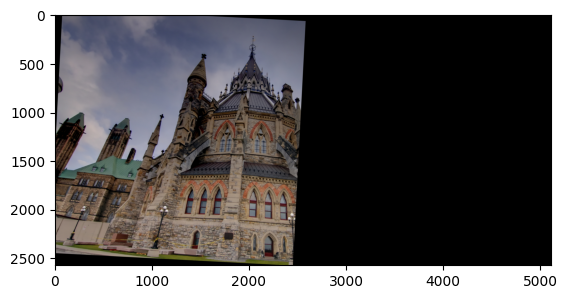

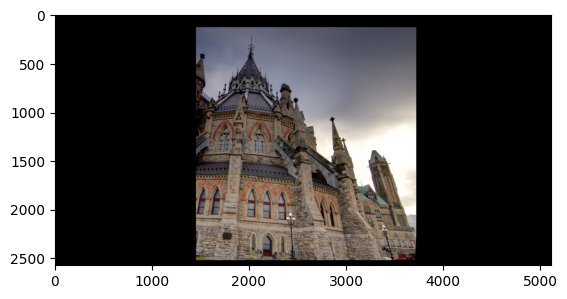

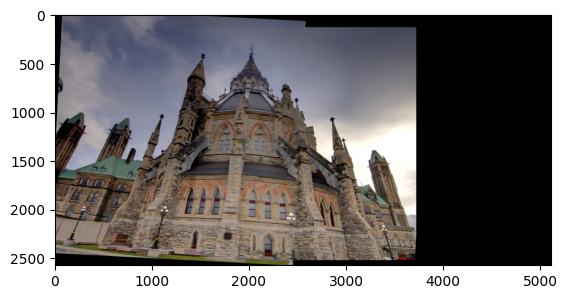

In [25]:
affine_t = torch.tensor(optimal_affine).unsqueeze(0).float()
trans_x = 1500
trans_y = 50  
trans = np.array([[1, 0, trans_x], [0, 1, trans_y], [0, 0, 1]], dtype=np.float32)
# Apply translation to the affine transformation matrix, to shift image to the right and down
affine_t = np.matmul(affine_t,trans)

img1 = plt.imread('parliament-left.jpg')
img1_t = kornia.utils.image_to_tensor(img1, False).float() / 255.0

# Transforming the img1 using the affine transformation 
affine_img_t = kornia.geometry.warp_perspective(img1_t, affine_t, [img1.shape[0], img1.shape[1]+img1.shape[1]])
plt.imshow(kornia.utils.tensor_to_image(affine_img_t))

img2 = plt.imread('parliament-right.jpg')
img2_t = kornia.utils.image_to_tensor(img2, False).float() / 255.0

# Placing img2 in a canvas that matches the dimensions of 'affine_img_t'
img2_mask = torch.zeros((3, affine_img_t.shape[2], affine_img_t.shape[3]))
# Translate img2_y by trans_y+75 and img2_x by trans_x-50
# Used margins like +75 in the height and -50 in the width, to improve alignment
img2_mask[:, trans_y+75:img2.shape[0]+trans_y+75, trans_x-50:img2.shape[1]+trans_x-50] = img2_t.squeeze(0)
plt.figure()
plt.imshow(kornia.utils.tensor_to_image(img2_mask))

# Final Stitching
mosaic = torch.maximum(affine_img_t.squeeze(0), img2_mask)
plt.figure()
plt.imshow(kornia.utils.tensor_to_image(mosaic))